# Capstone Project: Star Trek IMDB Ratings Predictor - Katya Kogan
---
## Part 1

- Goal: Predict the IMDB ratings from the scripts of Star Trek: The Next Generation, by each character's lines. 
    - This can have very useful real world applications in the film industry. With a model like this, scriptwriters can refer to it and determine if the episode(s) may be a hit or miss based on the character's spoken parts. 
   - In the long run, using a model like this could save producers of television shows tens of thousands of dollars in costs. On average, an episode of Star Trek: The Next Generation costs around 1.3 million dollars in production needs. Imagine producing an episode, only to find out that all of the hard work goes down the drain with poor reviews because of reduction in a certain character's spoken parts. Having producers make the choice of using a tool like an IMDB predictor ahead of time, they could save themselves a lot of grief in staying ahead of the curve (and maintaing a good rating!) before going into production.


- The dataset was received from [here](https://github.com/RTrek/startrekTNGdataset), a GitHub repository of one very nerdy person.  

- Goal in this notebook is to clean the dataset, and preprocess it for modeling, along with some handy visualizations. 

Let's begin with some EDA (Exploratory Data Analysis), as well as cleaning and modifying the data accordingly for our future models. 

In [1]:
# import all the relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')
# ensure plots load inline
%matplotlib inline
#give better plot style
plt.style.use('ggplot')

In [2]:
# read in the dataset
startrek_data = pd.read_csv(r'C:\Users\Katya\Documents\data\TNG.csv.gz', encoding= 'latin-1')

In [3]:
# take a look at the size
startrek_data.shape

(110176, 18)

There are 110,176 rows and 18 columns in this dataset. Let's take a look at it. 

In [4]:
startrek_data.head(10)

,Unnamed: 0,episode,productionnumber,setnames,characters,act,scenenumber,scenedetails,partnumber,type,who,text,speechdescription,Released,Episode,imdbRating,imdbID,Season
0,1,encounter at farpoint,NaN,NaN,NaN,TEASER,1,NaN,1,description,NaN,The U.S.S. Enterprise NCC 1701-D traveling at...,False,1987-09-26,1.0,6.9,tt0094030,1.0
1,2,encounter at farpoint,NaN,NaN,NaN,TEASER,1,NaN,2,speech,PICARD V.O.,"Captain's log, stardate 42353.7. Our destinat...",False,1987-09-26,1.0,6.9,tt0094030,1.0
2,3,encounter at farpoint,NaN,NaN,NaN,TEASER,2,NaN,3,description,NaN,on the gigantic new Enterprise NCC 1701-D.,False,1987-09-26,1.0,6.9,tt0094030,1.0
3,4,encounter at farpoint,NaN,NaN,NaN,TEASER,2,NaN,4,speech,PICARD V.O.,"My orders are to examine Farpoint, a starbase...",False,1987-09-26,1.0,6.9,tt0094030,1.0
4,5,encounter at farpoint,NaN,NaN,NaN,TEASER,3,NaN,5,description,NaN,"Huge, with a giant wall diagram showing the i...",False,1987-09-26,1.0,6.9,tt0094030,1.0
5,6,encounter at farpoint,NaN,NaN,NaN,TEASER,3,NaN,6,speech,PICARD V.O.,"acquainted with my new command, this Galaxy C...",True,1987-09-26,1.0,6.9,tt0094030,1.0
6,7,encounter at farpoint,NaN,NaN,NaN,TEASER,4,NaN,7,description,NaN,Showing the details and size of this enormous...,False,1987-09-26,1.0,6.9,tt0094030,1.0
7,8,encounter at farpoint,NaN,NaN,NaN,TEASER,4,NaN,8,speech,PICARD V.O.,I am still somewhat in awe of its size and co...,False,1987-09-26,1.0,6.9,tt0094030,1.0
8,9,encounter at farpoint,NaN,NaN,NaN,TEASER,5,NaN,9,description,NaN,With its huge windows revealing the immense s...,False,1987-09-26,1.0,6.9,tt0094030,1.0
9,10,encounter at farpoint,NaN,NaN,NaN,TEASER,5,NaN,10,speech,PICARD V.O.,"several key positions, most notably ...",True,1987-09-26,1.0,6.9,tt0094030,1.0


Since we are working specifically with the text data for our goal, we need to filter the dataset to only the lines where there is actually speech being said, rather than a scene description (to avoid the nuance of scene notes). 

In [5]:
# filtered to only rows where a charactor spoke in the episode
startrekspeech = startrek_data.loc[startrek_data['type'] == 'speech']

# take a look
startrekspeech.head(10)

,Unnamed: 0,episode,productionnumber,setnames,characters,act,scenenumber,scenedetails,partnumber,type,who,text,speechdescription,Released,Episode,imdbRating,imdbID,Season
1,2,encounter at farpoint,NaN,NaN,NaN,TEASER,1,NaN,2,speech,PICARD V.O.,"Captain's log, stardate 42353.7. Our destinat...",False,1987-09-26,1.0,6.9,tt0094030,1.0
3,4,encounter at farpoint,NaN,NaN,NaN,TEASER,2,NaN,4,speech,PICARD V.O.,"My orders are to examine Farpoint, a starbase...",False,1987-09-26,1.0,6.9,tt0094030,1.0
5,6,encounter at farpoint,NaN,NaN,NaN,TEASER,3,NaN,6,speech,PICARD V.O.,"acquainted with my new command, this Galaxy C...",True,1987-09-26,1.0,6.9,tt0094030,1.0
7,8,encounter at farpoint,NaN,NaN,NaN,TEASER,4,NaN,8,speech,PICARD V.O.,I am still somewhat in awe of its size and co...,False,1987-09-26,1.0,6.9,tt0094030,1.0
9,10,encounter at farpoint,NaN,NaN,NaN,TEASER,5,NaN,10,speech,PICARD V.O.,"several key positions, most notably ...",True,1987-09-26,1.0,6.9,tt0094030,1.0
12,13,encounter at farpoint,NaN,NaN,NaN,TEASER,7,NaN,13,speech,PICARD,"You will agree, Data, that Starfleet's instru...",False,1987-09-26,1.0,6.9,tt0094030,1.0
13,14,encounter at farpoint,NaN,NaN,NaN,TEASER,7,NaN,14,speech,DATA,Difficult ... how so? Simply solve the myster...,False,1987-09-26,1.0,6.9,tt0094030,1.0
14,15,encounter at farpoint,NaN,NaN,NaN,TEASER,7,NaN,15,speech,PICARD,As simple as that.,True,1987-09-26,1.0,6.9,tt0094030,1.0
15,16,encounter at farpoint,NaN,NaN,NaN,TEASER,7,NaN,16,speech,TROI,Farpoint Station. Even the name sounds myster...,False,1987-09-26,1.0,6.9,tt0094030,1.0
16,17,encounter at farpoint,NaN,NaN,NaN,TEASER,7,NaN,17,speech,PICARD,"The problem, Data, is that another life form ...",False,1987-09-26,1.0,6.9,tt0094030,1.0


In [6]:
startrekspeech.shape

(68487, 18)

In [7]:
# take a look at the types 
startrekspeech.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68487 entries, 1 to 110173
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         68487 non-null  int64  
 1   episode            68487 non-null  object 
 2   productionnumber   67797 non-null  object 
 3   setnames           61980 non-null  object 
 4   characters         62339 non-null  object 
 5   act                68487 non-null  object 
 6   scenenumber        68487 non-null  object 
 7   scenedetails       0 non-null      float64
 8   partnumber         68487 non-null  int64  
 9   type               68487 non-null  object 
 10  who                68486 non-null  object 
 11  text               68487 non-null  object 
 12  speechdescription  68487 non-null  bool   
 13  Released           67739 non-null  object 
 14  Episode            67739 non-null  float64
 15  imdbRating         67739 non-null  float64
 16  imdbID             67

### Data Dictionary

Filtering the data to only the spoken parts reduced the dataset to 62% of the original size. Now we're going to drop some columns as some of them are not relevant to our needs, as most of this information is related to the production of the show. 

We'll be dropping: 
- `Unnamed: 0` : this is a column that showed the order of the dialogue spoken, since we already filtered the set for speech, this is no longer needed. 
- `productionnumber` : the production number of the episode
- `setnames` : the names of the set
- `characters` : a list of characters that appear in the episode
- `act` : the act number within the episode
- `scenenumber` : the scene number within the act of the episode
- `scenedetails` : the details of a particular scene within the episode
- `partnumber` : the part number of the scene within the act of an episode 
- `type` : contained either 'speech' or 'description', since we already filtered for speech, we can drop this column
- `speechdescription`: shows if the speech contained a speech description for the particular line (which we can clean out) 
- `imdbID`: the ID number of the imdb rating

We'll be keeping: 
- `episode` : this shows the name of the episode 
- `Episode` : the episode number
- `Season` : the season number
- `who` : the character name(s)
- `Released`: the release date of the episode
- `text` : the line spoken by the character(s) for the row
- `imdbRating` : the target variable, our imdb rating

We're going to create our new dataframe that we'll working with. After its creation, we'll check for missing/null or duplicated values. 

In [8]:
# create a new dataframe with these filtered columns
StarTrek_df = startrekspeech.filter(['episode', 'Episode', 'Season', 'Released', 'who', 'text', 'imdbRating'], axis=1)

#sanity check
StarTrek_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68487 entries, 1 to 110173
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   episode     68487 non-null  object 
 1   Episode     67739 non-null  float64
 2   Season      67739 non-null  float64
 3   Released    67739 non-null  object 
 4   who         68486 non-null  object 
 5   text        68487 non-null  object 
 6   imdbRating  67739 non-null  float64
dtypes: float64(3), object(4)
memory usage: 4.2+ MB


### Cleaning and EDA

#### Missing Values and Duplicated Rows

Now we'll begin looking into missing values and any potential duplicate rows. 

In [9]:
# check for null/missing values
StarTrek_df.isna().sum()

episode         0
Episode       748
Season        748
Released      748
who             1
text            0
imdbRating    748
dtype: int64

There are 748 missing values across the rows, as well as one missing character. Let's double check for duplicates before we start handling this. 

In [10]:
#print the total number of duplicated rows
print(f"There are {StarTrek_df.duplicated().sum()} duplicate rows")

There are 854 duplicate rows


There are 854 duplicate rows, let's take a look to make sure that they are *actually* duplicated rows. 

In [11]:
# show duplicate rows
StarTrek_df.loc[StarTrek_df.duplicated(keep=False), :]

,episode,Episode,Season,Released,who,text,imdbRating
95,encounter at farpoint,1.0,1.0,1987-09-26,WORF,"Aye, sir.",6.9
156,encounter at farpoint,1.0,1.0,1987-09-26,WORF,"Aye, sir.",6.9
455,encounter at farpoint,1.0,1.0,1987-09-26,RIKER,Sir?,6.9
515,encounter at farpoint,1.0,1.0,1987-09-26,RIKER,Sir?,6.9
1191,the naked now,2.0,1.0,1987-10-03,PICARD,Picard here.,6.5
...,...,...,...,...,...,...,...
109920,all good things...,25.0,7.0,1994-05-23,PICARD,Thank you.,8.5
109975,all good things...,25.0,7.0,1994-05-23,DATA,"Aye, sir.",8.5
110029,all good things...,25.0,7.0,1994-05-23,DATA,"Yes, sir.",8.5
110106,all good things...,25.0,7.0,1994-05-23,PICARD,Thank you.,8.5


We can confirm that they are indeed duplicated, which leads us to the next step, dropping the duplicate values. 

We'll use`drop_duplicates()` on the original data, then we'll assign a new index using `reset_index()`. If we don't do this, the index will be missing values as a result of the drop, which doesn't help us in the future - as we have to maintain a defined index for ease of exploring. 

In [12]:
# dropping the duplicate rows in place
StarTrek_df.drop_duplicates(inplace=True)

In [13]:
# reseting the index 
StarTrek_df.reset_index(inplace=True, drop=True)

In [14]:
# sanity check
print(f"There are {StarTrek_df.duplicated().sum()} duplicate rows")

There are 0 duplicate rows


Now that we've dropped our duplicate rows, let's take another look at the missing values once more. 

In [15]:
# show null rows
StarTrek_df[StarTrek_df.isna().any(axis=1)]

,episode,Episode,Season,Released,who,text,imdbRating
47876,time's arrow,NaN,NaN,NaN,PICARD (V.O.),"Captain's log, stardate 45959.1. The Enterpri...",NaN
47877,time's arrow,NaN,NaN,NaN,PICARD (V.O.),All we've been told is that evidence has been...,NaN
47878,time's arrow,NaN,NaN,NaN,SCIENTIST,Work crews were down here installing seismic ...,NaN
47879,time's arrow,NaN,NaN,NaN,PICARD,And it's been determined that they date back ...,NaN
47880,time's arrow,NaN,NaN,NaN,DATA,The biofocal vision aide is typical of the er...,NaN
...,...,...,...,...,...,...,...
50873,rascals,NaN,NaN,NaN,GUINAN,Only if you're ready.,NaN
50874,rascals,NaN,NaN,NaN,YOUNG RO,It's not quite as bad as I remembered it... b...,NaN
50875,rascals,NaN,NaN,NaN,YOUNG RO,We better get going.,NaN
50876,rascals,NaN,NaN,NaN,GUINAN,There's no hurry. The Transporter will still ...,NaN


#### Imputing Missing Values 

We can see that there are missing values for `Episode`, `Season`, `Released`, and `imdbRating`. We're going to plug in these values manually, as this information is easily found [here](https://www.imdb.com/title/tt0708828/) (which is specifically for one episode, "time's arrow"). We're going to look up specifically for the one episode, "Time's Arrow", and input values. 

In [16]:
#looking up one episode
StarTrek_df.loc[StarTrek_df['episode'] == "time's arrow"]

,episode,Episode,Season,Released,who,text,imdbRating
47876,time's arrow,NaN,NaN,NaN,PICARD (V.O.),"Captain's log, stardate 45959.1. The Enterpri...",NaN
47877,time's arrow,NaN,NaN,NaN,PICARD (V.O.),All we've been told is that evidence has been...,NaN
47878,time's arrow,NaN,NaN,NaN,SCIENTIST,Work crews were down here installing seismic ...,NaN
47879,time's arrow,NaN,NaN,NaN,PICARD,And it's been determined that they date back ...,NaN
47880,time's arrow,NaN,NaN,NaN,DATA,The biofocal vision aide is typical of the er...,NaN
...,...,...,...,...,...,...,...
48270,time's arrow,NaN,NaN,NaN,BEVERLY,These strands appear to be biomagnetic... var...,NaN
48271,time's arrow,NaN,NaN,NaN,PICARD,A life-form... ?,NaN
48272,time's arrow,NaN,NaN,NaN,TROI,No. There is no life here... what I have sens...,NaN
48273,time's arrow,NaN,NaN,NaN,RIKER,My God... they're delivering more of them... ...,NaN


In [17]:
# plug in values manually (episode: time's arrow)
StarTrek_df.at[47876:48275, 'Season'] = int(5)
StarTrek_df.at[47876:48275, 'imdbRating'] = 8.4
StarTrek_df.at[47876:48275, 'Episode'] = int(26)
StarTrek_df.at[47876:48275, 'Released'] = '1995-06-14'

In [18]:
# sanity check for the particular episode
StarTrek_df.loc[StarTrek_df['episode'] == "time's arrow"]

,episode,Episode,Season,Released,who,text,imdbRating
47876,time's arrow,26.0,5.0,1995-06-14,PICARD (V.O.),"Captain's log, stardate 45959.1. The Enterpri...",8.4
47877,time's arrow,26.0,5.0,1995-06-14,PICARD (V.O.),All we've been told is that evidence has been...,8.4
47878,time's arrow,26.0,5.0,1995-06-14,SCIENTIST,Work crews were down here installing seismic ...,8.4
47879,time's arrow,26.0,5.0,1995-06-14,PICARD,And it's been determined that they date back ...,8.4
47880,time's arrow,26.0,5.0,1995-06-14,DATA,The biofocal vision aide is typical of the er...,8.4
...,...,...,...,...,...,...,...
48270,time's arrow,26.0,5.0,1995-06-14,BEVERLY,These strands appear to be biomagnetic... var...,8.4
48271,time's arrow,26.0,5.0,1995-06-14,PICARD,A life-form... ?,8.4
48272,time's arrow,26.0,5.0,1995-06-14,TROI,No. There is no life here... what I have sens...,8.4
48273,time's arrow,26.0,5.0,1995-06-14,RIKER,My God... they're delivering more of them... ...,8.4


We've successfully input the values for the episode, "Time's Arrow". Now we'll check for more missing values, and plug in the information accordingly. 

In [19]:
# check for more missing values to input
StarTrek_df[StarTrek_df.isna().any(axis=1)]

,episode,Episode,Season,Released,who,text,imdbRating
50536,rascals,NaN,NaN,NaN,PICARD (V.O.),"Captain's Log, Stardate 46235.7 Ensign Ro, Ke...",NaN
50537,rascals,NaN,NaN,NaN,PICARD,the tertiary level of the dig. They're typica...,NaN
50538,rascals,NaN,NaN,NaN,GUINAN,Mmmm-hmmmm.,NaN
50539,rascals,NaN,NaN,NaN,PICARD,"Now, see these markings... they're very simil...",NaN
50540,rascals,NaN,NaN,NaN,GUINAN,So... you went to one of the most beautiful p...,NaN
...,...,...,...,...,...,...,...
50873,rascals,NaN,NaN,NaN,GUINAN,Only if you're ready.,NaN
50874,rascals,NaN,NaN,NaN,YOUNG RO,It's not quite as bad as I remembered it... b...,NaN
50875,rascals,NaN,NaN,NaN,YOUNG RO,We better get going.,NaN
50876,rascals,NaN,NaN,NaN,GUINAN,There's no hurry. The Transporter will still ...,NaN


We'll repeat the same process again, and this time we're imputing for the episode, "Rascals" - which the info was found at IMDB again. 

In [20]:
# plug in values manually (episode: Rascals)
StarTrek_df.at[50536:50877, 'Season'] = int(6)
StarTrek_df.at[50536:50877, 'imdbRating'] = 7.4
StarTrek_df.at[50536:50877, 'Episode'] = int(7)
StarTrek_df.at[50536:50877, 'Released'] = '1995-08-23'

In [21]:
# sanity check for the particular episode
StarTrek_df.loc[StarTrek_df['episode'] == "rascals"]

,episode,Episode,Season,Released,who,text,imdbRating
50536,rascals,7.0,6.0,1995-08-23,PICARD (V.O.),"Captain's Log, Stardate 46235.7 Ensign Ro, Ke...",7.4
50537,rascals,7.0,6.0,1995-08-23,PICARD,the tertiary level of the dig. They're typica...,7.4
50538,rascals,7.0,6.0,1995-08-23,GUINAN,Mmmm-hmmmm.,7.4
50539,rascals,7.0,6.0,1995-08-23,PICARD,"Now, see these markings... they're very simil...",7.4
50540,rascals,7.0,6.0,1995-08-23,GUINAN,So... you went to one of the most beautiful p...,7.4
...,...,...,...,...,...,...,...
50872,rascals,7.0,6.0,1995-08-23,YOUNG RO,"It's my turn, isn't it?",7.4
50873,rascals,7.0,6.0,1995-08-23,GUINAN,Only if you're ready.,7.4
50874,rascals,7.0,6.0,1995-08-23,YOUNG RO,It's not quite as bad as I remembered it... b...,7.4
50875,rascals,7.0,6.0,1995-08-23,YOUNG RO,We better get going.,7.4


In [22]:
# check for more missing values to input
StarTrek_df[StarTrek_df.isna().any(axis=1)]

,episode,Episode,Season,Released,who,text,imdbRating
54117,birthright: part 2,17.0,6.0,1993-02-27,NaN,van'aj javDIch Qong DIr Sa'VIch ghIH yot quel...,7.3


We've successfully input the correct values for these missing episodes. There's only one row left that contains what looks like gibberish in the `text` column. We'll be dropping this row as well. 

In [23]:
# drop null values
StarTrek_df.dropna(inplace=True)

In [24]:
# confirmed no more missing values
StarTrek_df.isna().sum()

episode       0
Episode       0
Season        0
Released      0
who           0
text          0
imdbRating    0
dtype: int64

In [25]:
# sanity check
StarTrek_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67632 entries, 0 to 67632
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   episode     67632 non-null  object 
 1   Episode     67632 non-null  float64
 2   Season      67632 non-null  float64
 3   Released    67632 non-null  object 
 4   who         67632 non-null  object 
 5   text        67632 non-null  object 
 6   imdbRating  67632 non-null  float64
dtypes: float64(3), object(4)
memory usage: 4.1+ MB


#### Checking Dtypes of Columns 

There are some variables that need to be converted to their correct type. For example, the `Episode` and `Season` columns should be integers, as well as the `imdbRating`. In addition to that, the `Released` column is in datetime, and will be adjusted accordingly. 

In [26]:
# assigning dtypes to Episode, Season and Released
StarTrek_df['Episode'] = StarTrek_df['Episode'].astype('int') 
StarTrek_df['Season'] = StarTrek_df['Season'].astype('int') 
StarTrek_df['Released'] = pd.to_datetime(StarTrek_df['Released'])

#sanity check
StarTrek_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67632 entries, 0 to 67632
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   episode     67632 non-null  object        
 1   Episode     67632 non-null  int32         
 2   Season      67632 non-null  int32         
 3   Released    67632 non-null  datetime64[ns]
 4   who         67632 non-null  object        
 5   text        67632 non-null  object        
 6   imdbRating  67632 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(2), object(3)
memory usage: 3.6+ MB


In order to work with the `imdbRating` column for our future models, we'll round the values, and keep it as a float. 

In [27]:
# rounding the imdb rating to ensure accuracy of the data
StarTrek_df['imdbRating'] = round(StarTrek_df['imdbRating'])

# assigning the imdb column to integer
# StarTrek_df['imdbRating'] = StarTrek_df['imdbRating'].astype('int') 

# sanity check
StarTrek_df.head()

,episode,Episode,Season,Released,who,text,imdbRating
0,encounter at farpoint,1,1,1987-09-26,PICARD V.O.,"Captain's log, stardate 42353.7. Our destinat...",7.0
1,encounter at farpoint,1,1,1987-09-26,PICARD V.O.,"My orders are to examine Farpoint, a starbase...",7.0
2,encounter at farpoint,1,1,1987-09-26,PICARD V.O.,"acquainted with my new command, this Galaxy C...",7.0
3,encounter at farpoint,1,1,1987-09-26,PICARD V.O.,I am still somewhat in awe of its size and co...,7.0
4,encounter at farpoint,1,1,1987-09-26,PICARD V.O.,"several key positions, most notably ...",7.0


### Text Data Cleaning

We can see that within the `who` column that there are character names that come as one name, or paired together with a voiceover (V.O.), on-screen (O.S), or paired with another character.

We'll be performing some puncuation removal, as well as narrowing down the character column to a singular character name. 

Our next step is to clean the `who` column so that it's only the first name that appears.

In [28]:
# taking a closer look at the unique values of the who column
StarTrek_df['who'].unique().tolist()

[' PICARD V.O.',
 ' PICARD',
 ' DATA',
 ' TROI',
 ' WORF',
 ' CONN',
 ' "Q" (ELIZABETHAN)',
 ' MEDIC',
 ' "Q" (MARINE CAPTAIN)',
 ' PICARD "Q" (MARINE CAPTAIN) PICARD "Q" (MARINE CAPTAIN)',
 ' "Q" (21ST CENTURY)',
 ' TASHA',
 ' PICARD TROI',
 " PICARD'S INTERCOM VOICE",
 ' MANDARIN-BAILIFF',
 ' FUTURE MILITARY OFFICER',
 ' MILITARY OFFICER',
 ' "Q" (JUDGE)',
 ' "Q" (JUDGE) MANDARIN-BAILIFF',
 ' DATA "Q" (JUDGE)',
 ' OPS',
 " RIKER'S VOICE",
 ' ZORN',
 ' RIKER',
 " ZORN ZORN (Cont'd)",
 ' WESLEY',
 ' BEVERLY',
 ' MARKHAM',
 ' GEORDI/MARKHAM',
 ' GEORDI',
 ' BANDI WOMAN',
 " DATA'S VOICE",
 ' RIKER (V.O.)',
 ' ADMIRAL',
 " PICARD'S VOICE",
 ' PICARD WORF',
 " TROI'S VOICE",
 ' PICARD ZORN',
 ' YOUNG ENSIGN',
 ' COMPUTER VOICE',
 ' RIKER COMPUTER VOICE',
 ' RIKER DATA',
 " WESLEY'S VOICE",
 ' PICARD WES',
 ' BEVERLY WESLEY',
 " TASHA'S VOICE",
 ' WES',
 ' SECURITY VOICE',
 " ZORN'S VOICE",
 ' SECURITY POSITION',
 ' OPERATIONS POSITION',
 " ZORN'S VOICE PICARD",
 ' INTERCOM VOICE',
 ' "Q" 

Notice that within the`who` column that these names would be paired with a 'V.O'/'S.O', an extra "", an errant ' here and there, bracketed words, some have combinations of two or more characters and some characters are referred to in plural form or possessive. 

Now we're cleaning the `who` column of the aforementioned clutter. 

In [29]:
# remove the second name (or any word after the first)
StarTrek_df['who']=StarTrek_df['who'].str.replace(r"^(\s*(?:\S+\s+){1})\S+",r"\1")

# remove any unnecessary spaces
StarTrek_df['who'] = StarTrek_df['who'].str.strip()

# remove leading white spaces
StarTrek_df['who'] = StarTrek_df['who'].str.lstrip()

# remove punctuations 
StarTrek_df['who']=StarTrek_df['who'].str.replace(r"[^-9A-Za-z ]", "")

# Delete everything between the brackets
StarTrek_df['who'] = StarTrek_df['who'].str.replace(r"\(.*\)","")

After manually cleaning the `who` column with Pandas, we'll create a loop where the characters in the list are searched for (and if found, the name gets replaced with the clean version), and if none of the main cast is appearing for the particular row, it gets replaced with 'other'. 

In [30]:
main_cast = ['PICARD','WORF', 'BEVERLY', 'GEORDI', 'TROI',  'DATA', 'RIKER', 'WES', 'GUINAN', 'TASHA', 'PULASKI', 'Q' , 'LORE']

# loop through the rows and indexes of the StarTrek_df
for index, row in StarTrek_df.iterrows():
    # loop through the characters in main_cast
    for character in main_cast:
        # check to see if the character is in the who column from the main_cast
        if character in StarTrek_df.at[index, "who"]:
            # replace value with character 
            StarTrek_df.at[index, "who"] = character
    # check to see if the character is not in the main_cast        
    if StarTrek_df.at[index, "who"] not in main_cast:
        # replace with 'other'
        StarTrek_df.at[index, "who"] = "OTHER"
            

In [31]:
# quick check to see if it's all singular names 
StarTrek_df['who'].unique().tolist()

['PICARD',
 'DATA',
 'TROI',
 'WORF',
 'OTHER',
 'Q',
 'TASHA',
 'RIKER',
 'WES',
 'BEVERLY',
 'GEORDI',
 'LORE',
 'GUINAN',
 'PULASKI']

Now that the `who` column has been cleaned and organized properly, let's look at the meat of the dataset - our `text`. In order for our NLP analysis to go smoothly, we need to make sure the text is all lowercase (otherwise, we get unwanted repetitions), and remove punctuations as well. 

In [32]:
# converting the text to lowercase 
StarTrek_df['text']= StarTrek_df['text'].str.lower()

# remove punctuation and unnecessary characters 
StarTrek_df['text']=StarTrek_df['text'].str.replace(r"[^-9A-Za-z ]", "")

# Delete everything between the brackets
StarTrek_df['text'] = StarTrek_df['text'].str.replace(r"\(.*\)","")

StarTrek_df['text'] = StarTrek_df['text'].str.replace('-', '', regex=True)

We're creating a class with the purpose to remove stopwords and stem the text data for us, check out this [reference](https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27) where I received some inspiration. 

In [33]:
class CleanText(BaseEstimator, TransformerMixin):
    '''
    Define class and method to clean text data
    '''
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words)
    
    def stemming(self, input_text):
        porter = PorterStemmer() #Using PorterStemmer as stemming method
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_stopwords).apply(self.stemming)
        return clean_X
    

Now we can use this class to clean our `text` completely, because we'll be using the text data to feature engineer our character's spoken parts. 

In [34]:
#Instantiate the class method
clean = CleanText()
#Fit and transform `text` column
body = clean.fit_transform(StarTrek_df['text'])

In [35]:
#sanity check
StarTrek_df['text']

0         captains log stardate  our destination is pla...
1         my orders are to examine farpoint a starbase ...
2         acquainted with my new command this galaxy cl...
3         i am still somewhat in awe of its size and co...
4                      several key positions most notably 
                               ...                        
67628                               would you care to deal
67629                                         oh thank you
67630     i should have done this a long time ago i was...
67631                              you were always welcome
67632     so five card stud nothing wild the skys the l...
Name: text, Length: 67632, dtype: object

Now that we have a cleaned dataset, now let's do some feature engineering and add/modify more useful columns that could help us with our EDA. 

Next, we're adding a column that counts the number of words for each text line. 

In [36]:
# counts the number of words within the text column and input the value
StarTrek_df['Word_Count'] = [len(x.split()) for x in StarTrek_df['text'].tolist()]

In [37]:
#sanity check
StarTrek_df.sample(10)

,episode,Episode,Season,Released,who,text,imdbRating,Word_Count
38884,ensign ro,3,5,1991-10-05,OTHER,amnesty,8.0,1
54393,starship mine,18,6,1993-03-27,PICARD,i think we can resume the sequence counselor ...,8.0,18
18240,shades of gray,22,2,1989-07-15,RIKER,but im the first officer of this ship i have ...,3.0,14
31531,final mission,9,4,1990-11-17,OTHER,look at that,7.0,3
12078,loud as a whisper,5,2,1989-01-07,RIKER,standard orbit mister crusher,6.0,4
5463,11001001,14,1,1988-01-30,OTHER,we can complete,8.0,3
1407,code of honor,3,1,1987-10-10,OTHER,all my land all my goods all i have is yours ...,5.0,13
1356,code of honor,3,1,1987-10-10,PICARD,and having laid all that out lieut tasha we c...,5.0,15
63447,thine own self,16,7,1994-02-12,OTHER,my leg get it off get it off,8.0,8
57460,descent: part 1,26,6,1993-06-19,PICARD,tell me more about the one does he have a nam...,8.0,15


### Visualizations 

Let's visualize this information a little bit. I want to know what were the most frequent words spoken by some of the main characters from the show, as well as some recurring guests and villians. 

- PICARD
- RIKER
- DATA
- TROI
- WORF
- BEVERLY
- GEORDI
- TASHA
- WESLEY
- GUINAN 
- PULASKI
- Q
- LORE

#### WordCloud

We'll begin by creating a list of characters, and then create a loop for a WordCloud. Essentially a WordCloud shows the most spoken words (or word combinations) in a document. This effectively shows each character's individuality in an interesting graphic. 

In [38]:
# for char in main_cast: 
    
#     # selects the filtered dataframe to the character
#     StarTrek_Single = StarTrek_df.loc[StarTrek_df['who'] == char]
    
#     # select the text data
#     text = " ".join(lines for lines in StarTrek_Single.text)
    
#     # Create stopword list:
#     stopwords = set(STOPWORDS)

#     # Generate a word cloud image
#     wordcloud = WordCloud(stopwords=stopwords, background_color='black', mode="RGBA", width=2000, height=2000, colormap='plasma').generate(text)

#     # display the images 
#     fig = plt.figure(figsize=(10,10))
#     fig.patch.set_facecolor('black')
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.title(char, size=40, color='white')
#     plt.axis("off")
#     plt.savefig(char)
#     plt.show()
  

#### Most Common Words
Now that we've visualized what these characters said the most across the whole series, let's look into more interesting tidbits about this dataset. Namely, let's narrow down how often these words are mentioned across the whole corpus. 

In [39]:
#We can then use count the most common words in our corpus

#split the words, separate by space '_' and get the top 15 most common words.
text_most_common = Counter(" ".join(body).split()).most_common(15) 
# getting the word(s)
text_mc_word = [text_most_common[i][0] for i in range(len(text_most_common))]
# obtain the frequency
text_mc_freq = [text_most_common[i][1] for i in range(len(text_most_common))]

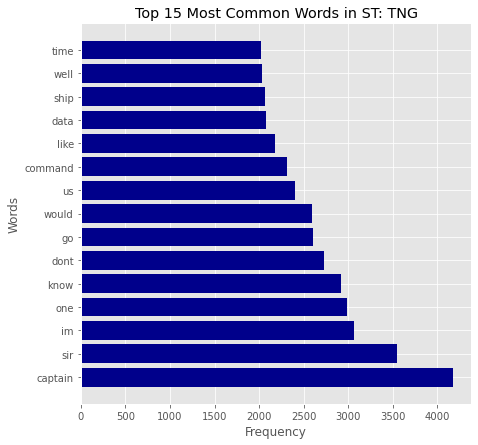

In [40]:
# plotting the most common words said across the whole corpus
plt.figure(figsize = (7,7))
#plot barh of the words, and their highest frequency
plt.barh(text_mc_word, text_mc_freq, color='darkblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title("Top 15 Most Common Words in ST: TNG")
plt.savefig("Top 15 Words")
plt.show()

The top 15 words are not so surprising. Every ship has its Captain, and these words fit within the realm of what's to be expected from a SciFi show that takes place with a sparefaring crew of people. 

Let's get some more interesting information, when did the show start and end? 

In [41]:
# get the min and max (start and end dates) for the corpus of episodes
print(f"The series started on: {StarTrek_df['Released'].min()}")
print(f"The series ended on: {StarTrek_df['Released'].max()}")

The series started on: 1987-09-26 00:00:00
The series ended on: 1995-08-23 00:00:00


What were the lowest and highest ratings received on IMDB? 

In [42]:
# the lowest and highest score for imdbRating
print(f"The lowest score received is: {StarTrek_df['imdbRating'].min()}")
print(f"The highest score received is: {StarTrek_df['imdbRating'].max()}")

The lowest score received is: 3.0
The highest score received is: 9.0


#### Rating Distribution
We'll be plotting a distribution of the ratings, as well as a time series of the entire series with the ratings plotted. 

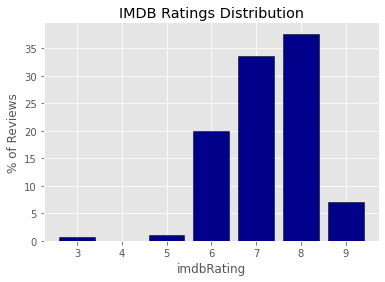

In [43]:
# looking at the distribution of the IMDB Ratings
values, counts = np.unique(StarTrek_df['imdbRating'], return_counts=True)
normalized_reviews = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_reviews * 100, edgecolor='black', color='darkblue')
plt.xlabel('imdbRating')
plt.ylabel('% of Reviews')
sns.despine()
plt.title("IMDB Ratings Distribution")
plt.savefig("IMDB Ratings Distribution")
plt.show()

The distribution of the ratings on this dataset show a normally distributed plot. There seems to be one episode that has a rating of 3. This will be considered an outlier, and will be dropped in the future. As a whole, the distribution is great to work with for modelling. 

There is one episode that has the lowest rating of 3, which isn't enough data for carry with us to the modelling stage. Even though there is another episode within the realm of a rating of 5, we'll be keeping it because it's closer to the main group of ratings, and the rating of 3 is too far from the normal distribution of the others. 

In [44]:
StarTrek_df.loc[StarTrek_df['imdbRating'] < 4 ]

,episode,Episode,Season,Released,who,text,imdbRating,Word_Count
18107,shades of gray,22,2,1989-07-15,GEORDI,commander,3.0,1
18108,shades of gray,22,2,1989-07-15,RIKER,im over here geordi,3.0,4
18109,shades of gray,22,2,1989-07-15,GEORDI,whats wrong,3.0,2
18110,shades of gray,22,2,1989-07-15,RIKER,something jabbed me in the calf,3.0,6
18111,shades of gray,22,2,1989-07-15,GEORDI,obrien commander rikers been injured lock o...,3.0,11
...,...,...,...,...,...,...,...,...
18614,shades of gray,22,2,1989-07-15,RIKER,why i feel fine,3.0,4
18615,shades of gray,22,2,1989-07-15,PULASKI,there may be some residual memory loss i just...,3.0,19
18616,shades of gray,22,2,1989-07-15,RIKER,of course i know who i am im captain jeanluc ...,3.0,15
18617,shades of gray,22,2,1989-07-15,PICARD,delighted youre feeling better captain the ad...,3.0,13


In [45]:
# dropping the rows that contain an imdb rating less than 4 by the index placements
StarTrek_df.drop(StarTrek_df.loc[18107:18618].index, inplace=True)

In [46]:
# sanity check
StarTrek_df.loc[StarTrek_df['imdbRating'] < 4]

,episode,Episode,Season,Released,who,text,imdbRating,Word_Count


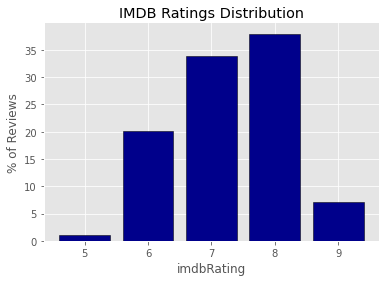

In [47]:
# looking at the distribution of the IMDB Ratings
values, counts = np.unique(StarTrek_df['imdbRating'], return_counts=True)
normalized_reviews = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_reviews * 100, edgecolor='black', color='darkblue')
plt.xlabel('imdbRating')
plt.ylabel('% of Reviews')
sns.despine()
plt.title("IMDB Ratings Distribution")
plt.savefig("IMDB Ratings Distribution")
plt.show()

Our distribution of the ratings looks very nice, and we can trust in moving forward in using these ratings for the modelling stage. 

#### Time Series of Ratings 
Let's see how the ratings perform across time, as the show as been around for several seasons. 

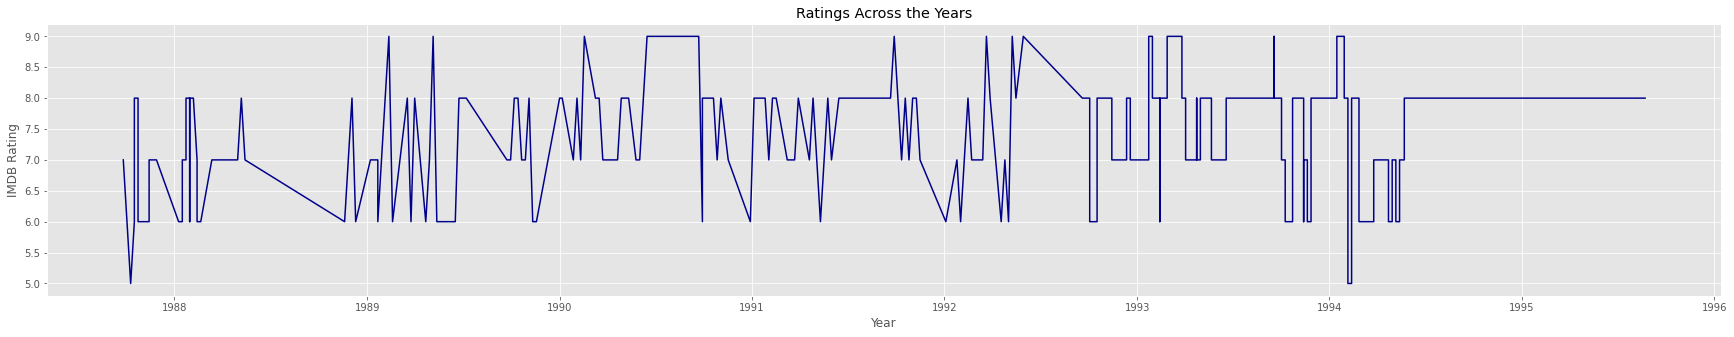

In [48]:
#plot the ratings count over the years
plt.figure(figsize = (30,5))
plt.plot(sorted(StarTrek_df['Released']), StarTrek_df['imdbRating'], color='darkblue')
plt.xlabel('Year')
plt.ylabel('IMDB Rating')
plt.title('Ratings Across the Years')
plt.savefig("Time Series with Ratings")
plt.show()

Let's take a closer look at the overall summary of the dataframe so far, and draw inspiration from and find more visualizations.

In [49]:
StarTrek_df.describe()

,Episode,Season,imdbRating,Word_Count
count,67120.000000,67120.000000,67120.000000,67120.000000
mean,13.152190,4.040629,7.297408,11.319234
std,7.373287,2.004748,0.903295,10.248759
min,1.000000,1.000000,5.000000,1.000000
25%,7.000000,2.000000,7.000000,4.000000
50%,13.000000,4.000000,7.000000,8.000000
75%,19.000000,6.000000,8.000000,15.000000
max,26.000000,7.000000,9.000000,372.000000


#### Line Length Counts

I'm curious to know how many words are said in each line, and how often does it happen? We'll plot a bar chart to show us the frequency of these lines, separated by bins of 5 (as the average of words per line is around 11). 

Text(0, 0.5, 'Total Number of Lines with the Total Words')

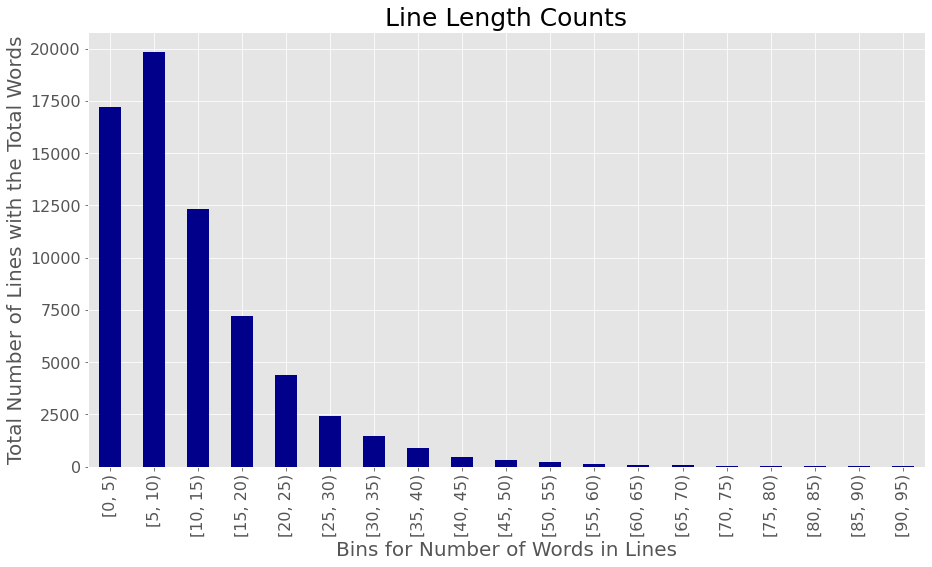

In [50]:
# the distribution of length of lines
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
# taking steps of 5 
step = 5
# range up 100 words in one line
bin_range = np.arange(0, 100, step)
#cutting up the word counts into bins 
out, bins  = pd.cut(StarTrek_df['Word_Count'], bins=bin_range, include_lowest=True, right=False, retbins=True)
# sort by the values
out.value_counts(sort=False).plot.bar(color='darkblue')
plt.title('Line Length Counts', size=25)
plt.tick_params(labelsize=16)
plt.xlabel('Bins for Number of Words in Lines', size=20)
plt.ylabel('Total Number of Lines with the Total Words', size=20)

Across the whole corpus, there's a very small amount of long lines from the script. This suggests to me that there aren't that many monologues in the show. I wonder if we can expand this information further. 

In [51]:
# for reference
StarTrek_df.head()

,episode,Episode,Season,Released,who,text,imdbRating,Word_Count
0,encounter at farpoint,1,1,1987-09-26,PICARD,captains log stardate our destination is pla...,7.0,19
1,encounter at farpoint,1,1,1987-09-26,PICARD,my orders are to examine farpoint a starbase ...,7.0,17
2,encounter at farpoint,1,1,1987-09-26,PICARD,acquainted with my new command this galaxy cl...,7.0,10
3,encounter at farpoint,1,1,1987-09-26,PICARD,i am still somewhat in awe of its size and co...,7.0,11
4,encounter at farpoint,1,1,1987-09-26,PICARD,several key positions most notably,7.0,5


In [52]:
print('Average Words Per Line:', round(StarTrek_df['Word_Count'].mean(), 2))
print('Lines Containing More than 100 Words: ', StarTrek_df[StarTrek_df['Word_Count'] >= 100].Word_Count.count())
print('\n')
print('Characters With More than 100 lines:')
print(StarTrek_df[StarTrek_df['Word_Count'] >= 100][['who', 'episode', 'Word_Count']])

Average Words Per Line: 11.32
Lines Containing More than 100 Words:  24


Characters With More than 100 lines:
           who               episode  Word_Count
8274     TASHA          skin of evil         100
9544    PICARD      the neutral zone         114
11516    OTHER  the outrageous okona         101
13111   PICARD  the measure of a man         116
13177   PICARD  the measure of a man         140
14234    RIKER            the royale         163
15002   PICARD     the icarus factor         115
16184   PICARD       samaritan snare         130
22254    OTHER          the defector         100
24787     DATA         the offspring         144
25545   PICARD            allegiance         103
29668    OTHER              brothers         100
30123    OTHER                family         372
38017   PICARD            redemption         111
38054   PICARD            redemption         108
39130    OTHER             ensign ro         165
41513   PICARD      a matter of time         102
44462  

It would seem that Picard has a LOT of monologues. Let's see what the total lines per episode is, rather than across the whole dataset. After creating this dataframe, we'll plot this information more clearly. 

#### Total Lines per Episode
**!!!NOTE!!!** 

The episode order is now in alphabetical order as a result of the `groupby()`, the `Episode ID` is inaccurate. However, we can reference the table above to see more information in regards to the episode name (as well as the total word count). 

In [53]:
# getting episode info for lines spoke by episode

ST_sorted = StarTrek_df.groupby('episode').count().reset_index()
ST_sorted.head()

,episode,Episode,Season,Released,who,text,imdbRating,Word_Count
0,11001001,426,426,426,426,426,426,426
1,a fistful of datas,302,302,302,302,302,302,302
2,a matter of honor,367,367,367,367,367,367,367
3,a matter of perspective,373,373,373,373,373,373,373
4,a matter of time,393,393,393,393,393,393,393


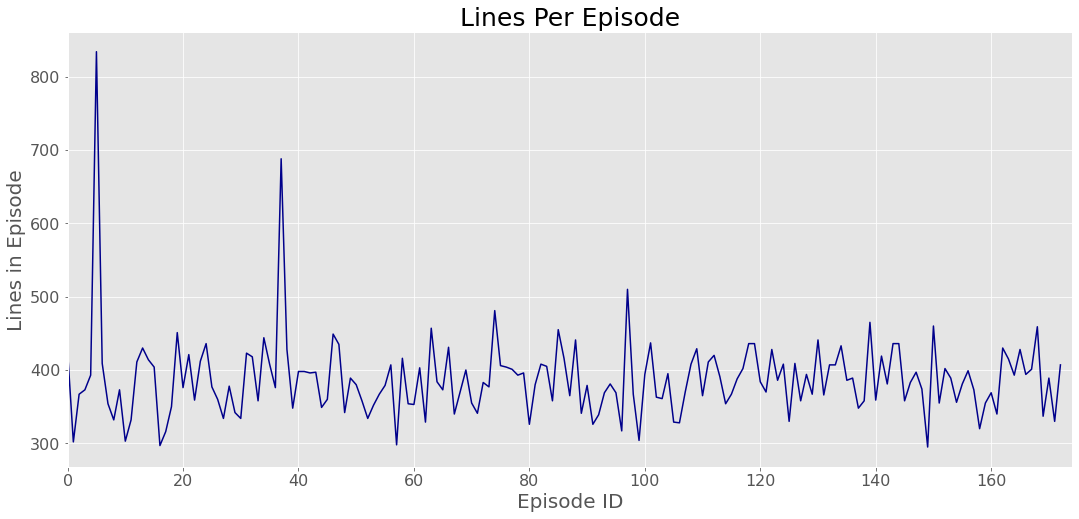

In [54]:
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111)
# sorted by the episode level 
ax.plot(ST_sorted.Word_Count, color='darkblue')
ax.set_title('Lines Per Episode', size=25)
ax.tick_params(labelsize=16)
ax.set_xlabel('Episode ID', size=20)
ax.set_ylabel('Lines in Episode', size=20)
ax.set_xlim((0, 174))
plt.show()

We can see that a particular episode ('All Good Things...') has 834 words, this makes complete sense because this episode is the series finale (y'know, saying Goodbyes and all that jazz). 

#### Total Words Spoken with IMDB Rating
Now, let's see if we can plot this information with the IMDB Rating. 

In [55]:
StarTrek_df

,episode,Episode,Season,Released,who,text,imdbRating,Word_Count
0,encounter at farpoint,1,1,1987-09-26,PICARD,captains log stardate our destination is pla...,7.0,19
1,encounter at farpoint,1,1,1987-09-26,PICARD,my orders are to examine farpoint a starbase ...,7.0,17
2,encounter at farpoint,1,1,1987-09-26,PICARD,acquainted with my new command this galaxy cl...,7.0,10
3,encounter at farpoint,1,1,1987-09-26,PICARD,i am still somewhat in awe of its size and co...,7.0,11
4,encounter at farpoint,1,1,1987-09-26,PICARD,several key positions most notably,7.0,5
...,...,...,...,...,...,...,...,...
67628,all good things...,25,7,1994-05-23,DATA,would you care to deal,8.0,5
67629,all good things...,25,7,1994-05-23,PICARD,oh thank you,8.0,3
67630,all good things...,25,7,1994-05-23,PICARD,i should have done this a long time ago i was...,8.0,20
67631,all good things...,25,7,1994-05-23,TROI,you were always welcome,8.0,4


In [1]:
fig = plt.figure(figsize = (15,7))
ax = fig.add_subplot(111)
# scatter plot of the word counts with the imdb ratings
ax.scatter(StarTrek_df.Word_Count, StarTrek_df.imdbRating,  alpha = .3, label='IMDB episode Rating', color = 'darkblue')
ax.tick_params(labelsize=10)
ax.set_title('Total Words Spoken by the IMDB Rating', size=20)
ax.set_xlabel('Total Words Spoken', size=15)
ax.set_xlim((0,200))
ax.tick_params(labelsize=20)
ax.set_ylabel('IMDB Rating', size = 15)
plt.legend(prop={'size':14})
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

## Prep for Modelling / Feature Engineering

Now that we have officially cleaned and organized our data, now we'll have to create new dataframes for modelling. 

Since there up to several hundred different characters across the show, and because they only appear once or twice at most, they are aren't contributing as much to the model. We are filtering the spoken words to only the main cast and some recurring villians. 

We're creating a new DataFrame entirely based on each of the main characters, grouped on the episode name, where we learn how many words each character spoke in the given episode. It'll also contain our `imdbRatings` column as well. 

Let's take a quick look at our original cleaned dataset for reference. 

In [57]:
# quick look
StarTrek_df.head()

,episode,Episode,Season,Released,who,text,imdbRating,Word_Count
0,encounter at farpoint,1,1,1987-09-26,PICARD,captains log stardate our destination is pla...,7.0,19
1,encounter at farpoint,1,1,1987-09-26,PICARD,my orders are to examine farpoint a starbase ...,7.0,17
2,encounter at farpoint,1,1,1987-09-26,PICARD,acquainted with my new command this galaxy cl...,7.0,10
3,encounter at farpoint,1,1,1987-09-26,PICARD,i am still somewhat in awe of its size and co...,7.0,11
4,encounter at farpoint,1,1,1987-09-26,PICARD,several key positions most notably,7.0,5


### Create Columns/Character

Now that we've created our list of characters (`main_cast`), we're creating a loop where: 

1. Filters down to the character chosen (in the list) 
2. Create a new individual column per character where it's their share of the `Word_Count` column
3. Group by the episode name
4. Appended the results to the list 

In [58]:
df_list = [] 

for character in main_cast:
    
    #filter to only the characters in the list
    StarTrek_Char = StarTrek_df.loc[StarTrek_df['who'] == character]
    
    #make a new column for each character's word count
    StarTrek_Char[character] = StarTrek_Char['Word_Count']
    
    #sum up the characters word counts for the specific episode 
    StarTrek_Char = StarTrek_Char.groupby(['episode'])[character].sum()
    
    #append results to the list, df_list
    df_list.append(StarTrek_Char)
    


In [59]:
# quick look
df_list

[episode
 11001001                        1067
 a fistful of datas               271
 a matter of honor                648
 a matter of perspective         1191
 a matter of time                1369
                                 ... 
 when the bough breaks           1015
 where no one has gone before    1261
 where silence has lease         1105
 who watches the watchers         907
 yesterday's enterprise          1124
 Name: PICARD, Length: 173, dtype: int64,
 episode
 11001001                         54
 a fistful of datas              601
 a matter of honor               204
 a matter of perspective          59
 a matter of time                175
                                ... 
 when the bough breaks            39
 where no one has gone before     32
 where silence has lease         226
 who watches the watchers         32
 yesterday's enterprise           62
 Name: WORF, Length: 171, dtype: int64,
 episode
 11001001                         136
 a fistful of datas         

We have our list of characters paired with their word count totals for each episode! Now, we need to reduce this list into a DataFrame where they're joined on the `episode` column. There should be only the `episode` (as the index), and the columns for each character with their total word count for that particular episode in the row. 

You might notice that the `episode` content is no longer in the serialized order of appearance. This is okay, and insignificant to our modelling purposes, as we are only interested in the`imdbRating` column as our dependent variable in the future. We care about the content per episode, not the order. 

Now we're going to convert our list into a dataframe on the `episode` column. 

In [60]:
from functools import reduce

# reducing the list into a table
WordCount_Char = reduce(lambda left, right:pd.merge(left, right, on=['episode'], how='outer'), df_list)

In [61]:
# sanity check
WordCount_Char.head()

,PICARD,WORF,BEVERLY,GEORDI,TROI,DATA,RIKER,WES,GUINAN,TASHA,PULASKI,Q,LORE
episode,,,,,,,,,,,,,
11001001,1067,54.0,136.0,166.0,NaN,333.0,1007,144.0,NaN,89.0,NaN,193.0,NaN
a fistful of datas,271,601.0,100.0,350.0,353.0,616.0,71,NaN,NaN,NaN,NaN,NaN,NaN
a matter of honor,648,204.0,NaN,NaN,NaN,187.0,1014,242.0,NaN,NaN,77.0,NaN,NaN
a matter of perspective,1191,59.0,28.0,498.0,94.0,353.0,741,80.0,NaN,NaN,NaN,NaN,NaN
a matter of time,1369,175.0,179.0,554.0,76.0,617.0,318,NaN,NaN,NaN,NaN,NaN,NaN


### Imputing Missing Values

We've successfully created our table! We have all the characters as their individual columns with their total word counts. However, we can see that there are some missing values immediately. This would make sense because not all of the characters appeared in every episode (for example, Q and Lore, who are recurring villians). We'll need to impute a 0 where there is a NaN. Let's look at all the missing rows. 

In [62]:
# show missing rows
WordCount_Char[WordCount_Char.isna().any(axis=1)]

,PICARD,WORF,BEVERLY,GEORDI,TROI,DATA,RIKER,WES,GUINAN,TASHA,PULASKI,Q,LORE
episode,,,,,,,,,,,,,
11001001,1067,54.0,136.0,166.0,NaN,333.0,1007,144.0,NaN,89.0,NaN,193.0,NaN
a fistful of datas,271,601.0,100.0,350.0,353.0,616.0,71,NaN,NaN,NaN,NaN,NaN,NaN
a matter of honor,648,204.0,NaN,NaN,NaN,187.0,1014,242.0,NaN,NaN,77.0,NaN,NaN
a matter of perspective,1191,59.0,28.0,498.0,94.0,353.0,741,80.0,NaN,NaN,NaN,NaN,NaN
a matter of time,1369,175.0,179.0,554.0,76.0,617.0,318,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
when the bough breaks,1015,39.0,336.0,70.0,43.0,184.0,437,597.0,NaN,40.0,NaN,NaN,NaN
where no one has gone before,1261,32.0,70.0,114.0,117.0,131.0,517,150.0,NaN,59.0,NaN,NaN,NaN
where silence has lease,1105,226.0,NaN,109.0,119.0,463.0,623,127.0,NaN,NaN,171.0,NaN,NaN


In [63]:
# replacing missing values with 0
WordCount_Char.fillna(0, inplace=True)

In [64]:
# checking for more missing values
WordCount_Char.isna().sum()

PICARD     0
WORF       0
BEVERLY    0
GEORDI     0
TROI       0
DATA       0
RIKER      0
WES        0
GUINAN     0
TASHA      0
PULASKI    0
Q          0
LORE       0
dtype: int64

We've correctly replaced all the of missing values with a zero, now we'll have to reset the index because the `episode` is currently our index, which is not optimal for modelling or EDA. 

In [65]:
# resetting the index
WordCount_Char.reset_index(level=0, inplace=True)

In [66]:
# sanity check
WordCount_Char.head()

,episode,PICARD,WORF,BEVERLY,GEORDI,TROI,DATA,RIKER,WES,GUINAN,TASHA,PULASKI,Q,LORE
0,11001001,1067,54.0,136.0,166.0,0.0,333.0,1007,144.0,0.0,89.0,0.0,193.0,0.0
1,a fistful of datas,271,601.0,100.0,350.0,353.0,616.0,71,0.0,0.0,0.0,0.0,0.0,0.0
2,a matter of honor,648,204.0,0.0,0.0,0.0,187.0,1014,242.0,0.0,0.0,77.0,0.0,0.0
3,a matter of perspective,1191,59.0,28.0,498.0,94.0,353.0,741,80.0,0.0,0.0,0.0,0.0,0.0
4,a matter of time,1369,175.0,179.0,554.0,76.0,617.0,318,0.0,0.0,0.0,0.0,0.0,0.0


I'm curious to know what were the total number of words said per character.

In [67]:
sum_ST = pd.DataFrame(WordCount_Char,columns=['PICARD','WORF', 'BEVERLY', 'GEORDI', 'TROI',  'DATA', 'RIKER', 'Q', 'LORE', 'WES', 'GUINAN', 'TASHA', 'PULASKI'])
sum_column = sum_ST.sum(axis=0)
print(sum_column)

PICARD     155742.0
WORF        34647.0
BEVERLY     42687.0
GEORDI      54854.0
TROI        37744.0
DATA        85751.0
RIKER       71187.0
Q           13934.0
LORE         2361.0
WES         13528.0
GUINAN       5874.0
TASHA        5562.0
PULASKI      5046.0
dtype: float64


With our index correct now, we can continue with some more feature engineering. We can see that each column has the total words per character, but we don't have a total words for the whole roster. So, we'll created a `Total_Word_Count` column that adds up all the characters that we have. 

In [68]:
# getting the total word count for each episode
WordCount_Char['Total_Word_Count'] = WordCount_Char.sum(axis=1)                     

In [69]:
# sanity check
WordCount_Char.sample(10)

,episode,PICARD,WORF,BEVERLY,GEORDI,TROI,DATA,RIKER,WES,GUINAN,TASHA,PULASKI,Q,LORE,Total_Word_Count
72,lonely among us,1061,125.0,387.0,282.0,354.0,554.0,609,214.0,0.0,285.0,0.0,0.0,0.0,3871.0
152,the vengeance factor,600,60.0,304.0,15.0,51.0,265.0,655,82.0,0.0,0.0,0.0,0.0,0.0,2032.0
115,the big goodbye,804,12.0,145.0,141.0,58.0,470.0,306,64.0,0.0,58.0,0.0,0.0,0.0,2058.0
168,when the bough breaks,1015,39.0,336.0,70.0,43.0,184.0,437,597.0,0.0,40.0,0.0,0.0,0.0,2761.0
121,the drumhead,1405,504.0,182.0,172.0,46.0,145.0,112,0.0,0.0,0.0,0.0,0.0,0.0,2566.0
147,the price,541,77.0,88.0,231.0,653.0,235.0,463,81.0,0.0,0.0,0.0,0.0,0.0,2369.0
69,legacy,686,189.0,157.0,221.0,69.0,841.0,584,0.0,0.0,0.0,0.0,0.0,0.0,2747.0
163,unification part 1,1264,208.0,82.0,219.0,48.0,599.0,556,0.0,0.0,0.0,0.0,0.0,0.0,2976.0
33,disaster,769,252.0,218.0,306.0,261.0,372.0,330,0.0,0.0,0.0,0.0,0.0,0.0,2508.0
91,redemption,1185,746.0,0.0,0.0,0.0,99.0,118,0.0,206.0,0.0,0.0,0.0,0.0,2354.0


In [70]:
WordCount_Char.to_csv(r"C:\Users\Katya\Documents\GitHub\Capstone-Project---BrainStation\StarTrek_WordCounts.csv")

### Convert to Percentage Values

Success. However, having numerical values doesn't correctly portray the significance per character by their total of words. Is 300 words a large portion of the speech said during that episode? 

In order to mitigate this, we'll convert the values into percentages, or more specifically, relative total word count. Our next steps are going to be creating a new group of columns specifically for the percentage values, and then drop the previous version (the total number). What we'll have left is just percentage values, and the total word count for reference. 


In [71]:
# getting the relative word count for each character instead of keeping the absolute values
character_percents = ['PICARD_PCT','WORF_PCT', 'BEVERLY_PCT', 'GEORDI_PCT', 'TROI_PCT',  'DATA_PCT', 'RIKER_PCT', 'WESLEY_PCT','GUINAN_PCT','TASHA_PCT','PULASKI_PCT', 'Q_PCT', 'LORE_PCT']

for index, character in enumerate(main_cast):
    
    # getting the percentage value for each character per episode
    WordCount_Char[character_percents[index]] = round((WordCount_Char[character] / WordCount_Char['Total_Word_Count']*100),2)

In [72]:
# sanity check
WordCount_Char.head()

,episode,PICARD,WORF,BEVERLY,GEORDI,TROI,DATA,RIKER,WES,GUINAN,...,GEORDI_PCT,TROI_PCT,DATA_PCT,RIKER_PCT,WESLEY_PCT,GUINAN_PCT,TASHA_PCT,PULASKI_PCT,Q_PCT,LORE_PCT
0,11001001,1067,54.0,136.0,166.0,0.0,333.0,1007,144.0,0.0,...,5.21,0.00,10.44,31.58,4.52,0.0,2.79,0.00,6.05,0.0
1,a fistful of datas,271,601.0,100.0,350.0,353.0,616.0,71,0.0,0.0,...,14.82,14.94,26.08,3.01,0.00,0.0,0.00,0.00,0.00,0.0
2,a matter of honor,648,204.0,0.0,0.0,0.0,187.0,1014,242.0,0.0,...,0.00,0.00,7.88,42.75,10.20,0.0,0.00,3.25,0.00,0.0
3,a matter of perspective,1191,59.0,28.0,498.0,94.0,353.0,741,80.0,0.0,...,16.36,3.09,11.60,24.34,2.63,0.0,0.00,0.00,0.00,0.0
4,a matter of time,1369,175.0,179.0,554.0,76.0,617.0,318,0.0,0.0,...,16.85,2.31,18.77,9.67,0.00,0.0,0.00,0.00,0.00,0.0


### Dropping Columns 

We've successfully created our columns with the percentage values, let's redefine this dataframe by dropping the absolute word counts from it. 

In [73]:
Relative_WordCount_Char = WordCount_Char.drop(columns=['PICARD', 'WORF', 'BEVERLY', 'GEORDI', 'TROI', 'DATA', 'RIKER', 'Q', 'LORE', 'WES', 'GUINAN', 'TASHA', 'PULASKI'])

print(Relative_WordCount_Char.shape)
Relative_WordCount_Char.head()

(173, 15)


,episode,Total_Word_Count,PICARD_PCT,WORF_PCT,BEVERLY_PCT,GEORDI_PCT,TROI_PCT,DATA_PCT,RIKER_PCT,WESLEY_PCT,GUINAN_PCT,TASHA_PCT,PULASKI_PCT,Q_PCT,LORE_PCT
0,11001001,3189.0,33.46,1.69,4.26,5.21,0.00,10.44,31.58,4.52,0.0,2.79,0.00,6.05,0.0
1,a fistful of datas,2362.0,11.47,25.44,4.23,14.82,14.94,26.08,3.01,0.00,0.0,0.00,0.00,0.00,0.0
2,a matter of honor,2372.0,27.32,8.60,0.00,0.00,0.00,7.88,42.75,10.20,0.0,0.00,3.25,0.00,0.0
3,a matter of perspective,3044.0,39.13,1.94,0.92,16.36,3.09,11.60,24.34,2.63,0.0,0.00,0.00,0.00,0.0
4,a matter of time,3288.0,41.64,5.32,5.44,16.85,2.31,18.77,9.67,0.00,0.0,0.00,0.00,0.00,0.0


Let's change the order of columns here, so it's a little more readable as well as renaming some of the columns that it's consistent throughout. 

In [74]:
# changing the order of columns
Relative_WordCount_Char = Relative_WordCount_Char[['episode', 'PICARD_PCT', 'RIKER_PCT', 'DATA_PCT', 'WORF_PCT', 'TROI_PCT','BEVERLY_PCT', 'GEORDI_PCT', 'Q_PCT', 'LORE_PCT' ,'WESLEY_PCT', 'GUINAN_PCT', 'TASHA_PCT', 'PULASKI_PCT', 'Total_Word_Count']]

#sanity check
Relative_WordCount_Char.head()

,episode,PICARD_PCT,RIKER_PCT,DATA_PCT,WORF_PCT,TROI_PCT,BEVERLY_PCT,GEORDI_PCT,Q_PCT,LORE_PCT,WESLEY_PCT,GUINAN_PCT,TASHA_PCT,PULASKI_PCT,Total_Word_Count
0,11001001,33.46,31.58,10.44,1.69,0.00,4.26,5.21,6.05,0.0,4.52,0.0,2.79,0.00,3189.0
1,a fistful of datas,11.47,3.01,26.08,25.44,14.94,4.23,14.82,0.00,0.0,0.00,0.0,0.00,0.00,2362.0
2,a matter of honor,27.32,42.75,7.88,8.60,0.00,0.00,0.00,0.00,0.0,10.20,0.0,0.00,3.25,2372.0
3,a matter of perspective,39.13,24.34,11.60,1.94,3.09,0.92,16.36,0.00,0.0,2.63,0.0,0.00,0.00,3044.0
4,a matter of time,41.64,9.67,18.77,5.32,2.31,5.44,16.85,0.00,0.0,0.00,0.0,0.00,0.00,3288.0


In [75]:
# renaming the columns
Relative_WordCount_Char = Relative_WordCount_Char.rename(columns={"episode": "EPISODE", "Total_Word_Count": "TOTAL_WORDS"})

### Grouping by Episode Name 
We've created the new dataframe, which we'll be joining the `imdbRating` contents to. First, we'll have to group the contents by episode name before we join them. I'm keeping the `text` column in place for reference. 

In [76]:
# filtered original cleaned dataframe to only episode and imdb rating
StarTrek_Text = StarTrek_df.filter(['episode', 'imdbRating', 'text'])

#sanity check
StarTrek_Text.head()

,episode,imdbRating,text
0,encounter at farpoint,7.0,captains log stardate our destination is pla...
1,encounter at farpoint,7.0,my orders are to examine farpoint a starbase ...
2,encounter at farpoint,7.0,acquainted with my new command this galaxy cl...
3,encounter at farpoint,7.0,i am still somewhat in awe of its size and co...
4,encounter at farpoint,7.0,several key positions most notably


In [77]:
# grouping the text data and ratings by episode 
StarTrek_Text2 = StarTrek_Text.groupby('episode').agg({'text': lambda x: ', '.join(x), 'imdbRating':'mean'})

In [78]:
# sanity check
print(StarTrek_Text2.shape)
StarTrek_Text2.head()


(173, 2)


,text,imdbRating
episode,,
11001001,captains log stardate 9 the enterprise has be...,8.000000
a fistful of datas,captains log stardate the enterprise has ent...,7.996689
a matter of honor,"we are approaching starbase onesevennine, ha...",8.000000
a matter of perspective,we have arrived at tanuga four captain the aw...,7.000000
a matter of time,captains log stardate the enterprise is on i...,7.000000


We've grouped the `text` and `imdbRating` columns successfully, and now we'll be adding the `imdbRating` column to the main dataframe. 

In [79]:
# quick look at the main dataframe
Relative_WordCount_Char

,EPISODE,PICARD_PCT,RIKER_PCT,DATA_PCT,WORF_PCT,TROI_PCT,BEVERLY_PCT,GEORDI_PCT,Q_PCT,LORE_PCT,WESLEY_PCT,GUINAN_PCT,TASHA_PCT,PULASKI_PCT,TOTAL_WORDS
0,11001001,33.46,31.58,10.44,1.69,0.00,4.26,5.21,6.05,0.0,4.52,0.0,2.79,0.00,3189.0
1,a fistful of datas,11.47,3.01,26.08,25.44,14.94,4.23,14.82,0.00,0.0,0.00,0.0,0.00,0.00,2362.0
2,a matter of honor,27.32,42.75,7.88,8.60,0.00,0.00,0.00,0.00,0.0,10.20,0.0,0.00,3.25,2372.0
3,a matter of perspective,39.13,24.34,11.60,1.94,3.09,0.92,16.36,0.00,0.0,2.63,0.0,0.00,0.00,3044.0
4,a matter of time,41.64,9.67,18.77,5.32,2.31,5.44,16.85,0.00,0.0,0.00,0.0,0.00,0.00,3288.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,when the bough breaks,36.76,15.83,6.66,1.41,1.56,12.17,2.54,0.00,0.0,21.62,0.0,1.45,0.00,2761.0
169,where no one has gone before,51.45,21.09,5.34,1.31,4.77,2.86,4.65,0.00,0.0,6.12,0.0,2.41,0.00,2451.0
170,where silence has lease,37.55,21.17,15.73,7.68,4.04,0.00,3.70,0.00,0.0,4.32,0.0,0.00,5.81,2943.0
171,who watches the watchers,53.13,15.88,7.91,1.87,10.37,8.08,2.75,0.00,0.0,0.00,0.0,0.00,0.00,1707.0


We'll have to define the `imdbRating` column so that we can append these results to the main dataframe. 

In [80]:
# # resetting the index as well as defining the documents
# text = StarTrek_Text2['text'].reset_index(drop=True)
# text

In [81]:
#adding a new column from our new variable
# Relative_WordCount_Char['SCRIPT'] = text

In [82]:
# create a new column, and reset the index as well
rating = StarTrek_Text2['imdbRating'].reset_index(drop=True)

In [83]:
# create a new rating column from the grouped dataframe.
Relative_WordCount_Char['RATING'] = rating
Relative_WordCount_Char

,EPISODE,PICARD_PCT,RIKER_PCT,DATA_PCT,WORF_PCT,TROI_PCT,BEVERLY_PCT,GEORDI_PCT,Q_PCT,LORE_PCT,WESLEY_PCT,GUINAN_PCT,TASHA_PCT,PULASKI_PCT,TOTAL_WORDS,RATING
0,11001001,33.46,31.58,10.44,1.69,0.00,4.26,5.21,6.05,0.0,4.52,0.0,2.79,0.00,3189.0,8.000000
1,a fistful of datas,11.47,3.01,26.08,25.44,14.94,4.23,14.82,0.00,0.0,0.00,0.0,0.00,0.00,2362.0,7.996689
2,a matter of honor,27.32,42.75,7.88,8.60,0.00,0.00,0.00,0.00,0.0,10.20,0.0,0.00,3.25,2372.0,8.000000
3,a matter of perspective,39.13,24.34,11.60,1.94,3.09,0.92,16.36,0.00,0.0,2.63,0.0,0.00,0.00,3044.0,7.000000
4,a matter of time,41.64,9.67,18.77,5.32,2.31,5.44,16.85,0.00,0.0,0.00,0.0,0.00,0.00,3288.0,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,when the bough breaks,36.76,15.83,6.66,1.41,1.56,12.17,2.54,0.00,0.0,21.62,0.0,1.45,0.00,2761.0,6.000000
169,where no one has gone before,51.45,21.09,5.34,1.31,4.77,2.86,4.65,0.00,0.0,6.12,0.0,2.41,0.00,2451.0,8.000000
170,where silence has lease,37.55,21.17,15.73,7.68,4.04,0.00,3.70,0.00,0.0,4.32,0.0,0.00,5.81,2943.0,7.000000
171,who watches the watchers,53.13,15.88,7.91,1.87,10.37,8.08,2.75,0.00,0.0,0.00,0.0,0.00,0.00,1707.0,8.000000


In [84]:
# Relative_WordCount_Char['RATING'] = round(Relative_WordCount_Char['RATING']).astype('int')

In [85]:
PCT_Graph = Relative_WordCount_Char[['PICARD_PCT', 'RIKER_PCT', 'DATA_PCT', 'WORF_PCT', 'TROI_PCT','BEVERLY_PCT', 'GEORDI_PCT', 'Q_PCT', 'LORE_PCT' ,'WESLEY_PCT', 'GUINAN_PCT', 'TASHA_PCT', 'PULASKI_PCT', 'RATING']]
PCT_Graph.to_csv(r"C:\Users\Katya\Documents\GitHub\Capstone-Project---BrainStation\PCT_Graph.csv")

In [86]:
#quick overall look at our final dataframe
PCT_Graph.describe()

,PICARD_PCT,RIKER_PCT,DATA_PCT,WORF_PCT,TROI_PCT,BEVERLY_PCT,GEORDI_PCT,Q_PCT,LORE_PCT,WESLEY_PCT,GUINAN_PCT,TASHA_PCT,PULASKI_PCT,RATING
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,30.105954,13.780751,15.688150,7.041098,7.363006,7.924566,10.053526,2.144220,0.376012,2.579827,1.096647,0.963815,0.882197,7.312120
std,14.787233,9.330057,11.563336,9.462369,9.161519,9.758427,9.783130,7.263255,2.884096,5.862507,2.827123,3.119654,3.253685,0.912255
min,0.220000,0.330000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,18.060000,7.330000,7.530000,2.220000,1.790000,1.620000,3.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
50%,29.160000,12.210000,12.900000,4.280000,4.510000,5.270000,6.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
75%,39.790000,18.290000,21.380000,7.130000,9.320000,10.750000,13.580000,0.000000,0.000000,2.670000,0.000000,0.000000,0.000000,8.000000
max,69.200000,57.310000,59.080000,67.030000,61.370000,62.440000,46.610000,45.080000,25.640000,36.420000,14.820000,22.200000,23.350000,9.000000


In [87]:
PCT_Graph.shape

(173, 14)

In [88]:
# Relative_WordCount_Char.to_csv(r"C:\Users\Katya\Documents\GitHub\Capstone-Project---BrainStation\StarTrek_Prepped.csv")

## Conclusion

Across this whole process, we've maintained the correct shape (173 episodes, means 173 rows), and displayed the percentage total of words spoken per main character in the series, as well as the IMDB Rating attached. 

In Part 2, we'll be splitting the data for modelling purposes. 

This concludes our cleaning, EDA, and prep/feature engineering portion of the project. Refer to Part 2 for next steps. 